<a href="https://colab.research.google.com/github/christinaxliu/research/blob/main/STS/Exoplanet_Habitability_RandomForest_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source code for the research project of Analyzing the Impacts of Stellar and Planetary Parameters to Exoplanet Habitability through Explainable Machine Learning.

The source code contains:
* Data processing and feature engineering for Random Forest and XGBoost classifiers to predict exoplanet habitability.
* Hyperparameter tuning of Random Forest and XGBoost classifiers through exhaustic search.
* Feature importance analysis through SHAP (https://shap.readthedocs.io/en/latest/) on Random Forest and XGBoost classifiers.

In [ ]:
pip install shap

In [ ]:
!pip uninstall miceforest -y
!pip install miceforest --upgrade --no-cache-dir

In [ ]:
import warnings
import os
import pydotplus
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from collections import Counter
import miceforest as mf
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from IPython.display import Image
from six import StringIO
import pickle
import shap
from google.colab import drive

In [ ]:
warnings.simplefilter('ignore')
shap.initjs()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Feature names
feature_columns = [
    'sy_pnum: Number of Planets in the Planetary System',
    'pl_orbsmax: Planet Orbit Semi-Major Axis [au]',
    'pl_rade: Planet Radius [Earth Radius]',
    'pl_bmasse: Planet Mass or Mass*sin(i) [Earth Mass]',
    'pl_orbeccen: Planet Orbit Eccentricity',
    'pl_orbincl: Planet Inclination [deg]',
    'st_teff: Stellar Effective Temperature [K]',
    'st_rad: Stellar Radius [Solar Radius]',
    'st_mass: Stellar Mass [Solar mass]',
    'st_met: Stellar Metallicity [dex]',
    'st_age: Stellar Age [Gyr]',
    'ra: Right Ascension of the Planetary System [decimal]',
    'dec: Declination of the Planetary System [decimal]',
    'sy_kmag: Stellar Ks (2MASS) Magnitude',
    'st_metratio__[Fe/H]: Stellar Metallicity Ratio',
    'st_metratio__[M/H]: Stellar Metallicity Ratio'
]

In [ ]:
nasa_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/STS/NASA_PSCompPars_2025.10.04.csv'
nasa_exoplanets_data = pd.read_table(nasa_exoplanets_filename,
                                      skiprows=178,
                                      sep=',',
                                      header=None,
                                      index_col=None,
                                      names = ['pl_name', 'hostname', 'sy_snum', 'sy_pnum',
                                               'discoverymethod', 'disc_year', 'disc_facility', 'disc_telescope', 'disc_instrument',
                                               'pl_controv_flag',
                                               'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim',
                                               'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                               'pl_angsep', 'pl_angseperr1', 'pl_angseperr2', 'pl_angseplim',
                                               'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim',
                                               'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                               'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim',
                                               'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                               'pl_bmassprov',
                                               'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_denslim',
                                               'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                               'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim',
                                               'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                               'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_orbincllim',
                                               'ttv_flag',
                                               'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim',
                                               'pl_trandur', 'pl_trandurerr1', 'pl_trandurerr2', 'pl_trandurlim',
                                               'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'pl_ratdorlim',
                                               'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_ratrorlim',
                                               'pl_occdep', 'pl_occdeperr1', 'pl_occdeperr2', 'pl_occdeplim',
                                               'pl_orbtper', 'pl_orbtpererr1', 'pl_orbtpererr2', 'pl_orbtperlim',
                                               'pl_orblper', 'pl_orblpererr1', 'pl_orblpererr2', 'pl_orblperlim',
                                               'pl_rvamp', 'pl_rvamperr1', 'pl_rvamperr2', 'pl_rvamplim',
                                               'pl_projobliq', 'pl_projobliqerr1', 'pl_projobliqerr2', 'pl_projobliqlim',
                                               'pl_trueobliq', 'pl_trueobliqerr1', 'pl_trueobliqerr2', 'pl_trueobliqlim',
                                               'st_spectype',
                                               'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim',
                                               'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim',
                                               'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim',
                                               'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim',
                                               'st_metratio',
                                               'st_lum', 'st_lumerr1', 'st_lumerr2', 'st_lumlim',
                                               'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim',
                                               'st_age', 'st_ageerr1', 'st_ageerr2', 'st_agelim',
                                               'st_dens', 'st_denserr1', 'st_denserr2', 'st_denslim',
                                               'st_vsin', 'st_vsinerr1', 'st_vsinerr2', 'st_vsinlim',
                                               'st_rotp', 'st_rotperr1', 'st_rotperr2', 'st_rotplim',
                                               'st_radv', 'st_radverr1', 'st_radverr2', 'st_radvlim',
                                               'rastr', 'ra', 'decstr', 'dec',
                                               'sy_dist', 'sy_disterr1', 'sy_disterr2',
                                               'sy_bmag', 'sy_bmagerr1', 'sy_bmagerr2',
                                               'sy_vmag', 'sy_vmagerr1', 'sy_vmagerr2',
                                               'sy_kmag', 'sy_kmagerr1', 'sy_kmagerr2',
                                               'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2',
                                               'sy_tmag', 'sy_tmagerr1', 'sy_tmagerr2',
                                               'sy_kepmag', 'sy_kepmagerr1', 'sy_kepmagerr2'],
                                      skipfooter=0,
                                      engine='python')

In [ ]:
# Sanity check the first several rows of data to ensure data is read correctly
nasa_exoplanets_data.head()

pl_name  hostname  sy_snum  sy_pnum  discoverymethod  disc_year  \
0    11 Com b    11 Com        2        1  Radial Velocity       2007   
1    11 UMi b    11 UMi        1        1  Radial Velocity       2009   
2    14 And b    14 And        1        1  Radial Velocity       2008   
3    14 Her b    14 Her        1        2  Radial Velocity       2002   
4  16 Cyg B b  16 Cyg B        3        1  Radial Velocity       1996   

                            disc_facility                 disc_telescope  \
0                        Xinglong Station               2.16 m Telescope   
1  Thueringer Landessternwarte Tautenburg  2.0 m Alfred Jensch Telescope   
2       Okayama Astrophysical Observatory               1.88 m Telescope   
3                  W. M. Keck Observatory          10 m Keck I Telescope   
4                  Multiple Observatories            Multiple Telescopes   

              disc_instrument  pl_controv_flag  ...  sy_kmagerr2  sy_gaiamag  \
0  Coude Echelle Spectrograph                0  ...       -0.346     4.44038   
1  Coude Echelle Spectrograph                0  ...       -0.270     4.56216   
2  HIDES Echelle Spectrograph                0  ...       -0.240     4.91781   
3          HIRES Spectrometer                0  ...       -0.016     6.38300   
4        Multiple Instruments                0  ...       -0.016     6.06428   

   sy_gaiamagerr1  sy_gaiamagerr2  sy_tmag  sy_tmagerr1  sy_tmagerr2  \
0        0.003848       -0.003848  3.83790       0.0071      -0.0071   
1        0.003903       -0.003903  3.82294       0.0075      -0.0075   
2        0.002826       -0.002826  4.32140       0.0073      -0.0073   
3        0.000351       -0.000351  5.86310       0.0060      -0.0060   
4        0.000603       -0.000603  5.62810       0.0060      -0.0060   

   sy_kepmag  sy_kepmagerr1  sy_kepmagerr2  
0        NaN            NaN            NaN  
1        NaN            NaN            NaN  
2        NaN            NaN            NaN  
3        NaN            NaN            NaN  
4      6.095            NaN            NaN  

[5 rows x 171 columns]

In [ ]:
# Sanity check the last several rows of data to ensure data is read correctly.
nasa_exoplanets_data.tail()

pl_name hostname  sy_snum  sy_pnum  discoverymethod  disc_year  \
6017  ups And b  ups And        2        3  Radial Velocity       1996   
6018  ups And c  ups And        2        3  Radial Velocity       1999   
6019  ups And d  ups And        2        3  Radial Velocity       1999   
6020  ups Leo b  ups Leo        1        1  Radial Velocity       2021   
6021   xi Aql b   xi Aql        1        1  Radial Velocity       2007   

                          disc_facility                   disc_telescope  \
6017                   Lick Observatory  3.0 m C. Donald Shane Telescope   
6018             Multiple Observatories              Multiple Telescopes   
6019             Multiple Observatories              Multiple Telescopes   
6020  Okayama Astrophysical Observatory                 1.88 m Telescope   
6021  Okayama Astrophysical Observatory                 1.88 m Telescope   

                    disc_instrument  pl_controv_flag  ...  sy_kmagerr2  \
6017  Hamilton Echelle Spectrograph                0  ...       -0.274   
6018           Multiple Instruments                0  ...       -0.274   
6019           Multiple Instruments                0  ...       -0.274   
6020     HIDES Echelle Spectrograph                0  ...       -0.248   
6021     HIDES Echelle Spectrograph                0  ...       -0.220   

      sy_gaiamag  sy_gaiamagerr1  sy_gaiamagerr2  sy_tmag  sy_tmagerr1  \
6017     3.98687        0.008937       -0.008937   3.6137       2.1920   
6018     3.98687        0.008937       -0.008937   3.6137       2.1920   
6019     3.98687        0.008937       -0.008937   3.6137       2.1920   
6020     4.03040        0.008513       -0.008513   3.4462       2.0505   
6021     4.42501        0.003837       -0.003837   3.8144       0.0072   

      sy_tmagerr2  sy_kepmag  sy_kepmagerr1  sy_kepmagerr2  
6017      -2.1920        NaN            NaN            NaN  
6018      -2.1920        NaN            NaN            NaN  
6019      -2.1920        NaN            NaN            NaN  
6020      -2.0505        NaN            NaN            NaN  
6021      -0.0072        NaN            NaN            NaN  

[5 rows x 171 columns]

In [ ]:
# Get the statistics about the data
nasa_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5445 entries, 1 to 6021
Columns: 171 entries, pl_name to sy_kepmagerr2
dtypes: float64(155), int64(5), object(11)
memory usage: 7.1+ MB


In [ ]:
# Only selects exoplanets with pl_controv_flag == 0
nasa_exoplanets_data = nasa_exoplanets_data.loc[(nasa_exoplanets_data['pl_controv_flag'] == 0)]

In [ ]:
# Limit the data to single-star systems
nasa_exoplanets_data = nasa_exoplanets_data.loc[
    (~np.isnan(nasa_exoplanets_data['sy_snum'])) & (nasa_exoplanets_data['sy_snum'] == 1)]

In [ ]:
hwc_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/STS/hwc_2025.10.04.csv'
hwc_exoplanets_data = pd.read_csv(hwc_exoplanets_filename)
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


In [ ]:
# Only conside the entries in the data that contain the P_HABITABLE data fields for labeling
hwc_exoplanets_data = hwc_exoplanets_data.loc[~np.isnan(hwc_exoplanets_data['P_HABITABLE'])]
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.1+ MB


In [ ]:
# Join NASA Exoplant Archive data with HWC data
exoplanets_data = pd.merge(nasa_exoplanets_data,
                           hwc_exoplanets_data[['P_HABITABLE']],
                           how="left",
                           left_on=nasa_exoplanets_data['pl_name'].str.lower(),
                           right_on=hwc_exoplanets_data['P_NAME'].str.lower())
exoplanets_data = exoplanets_data.drop(['key_0'], axis = 1)

# Change any fields with empty spaces to NaN values so we can clean them up
exoplanets_data = exoplanets_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
exoplanets_data = exoplanets_data.loc[~np.isnan(exoplanets_data['P_HABITABLE'])]

exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 0 to 5444
Columns: 172 entries, pl_name to P_HABITABLE
dtypes: float64(156), int64(5), object(11)
memory usage: 6.7+ MB


In [ ]:
exoplanets_data.to_csv('/content/drive/My Drive/Colab Notebooks/research/STS/NasaJoinedWithHWCData_2025.10.04.csv')

In [ ]:
# Drop data fields that are not relevant to the training
training_prep_data = exoplanets_data.drop(['pl_name', 'hostname', 'sy_snum',
                                           'discoverymethod', 'disc_year', 'disc_facility', 'disc_telescope', 'disc_instrument',
                                           'pl_controv_flag',
                                           'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim',
                                           'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                           'pl_angseperr1', 'pl_angseperr2', 'pl_angseplim',
                                           'pl_radeerr1', 'pl_radeerr2', 'pl_radelim',
                                           'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                           'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim',
                                           'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                           'pl_denserr1', 'pl_denserr2', 'pl_denslim',
                                           'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                           'pl_insolerr1', 'pl_insolerr2', 'pl_insollim',
                                           'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                           'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_orbincllim',
                                           'ttv_flag',
                                           'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim',
                                           'pl_trandurerr1', 'pl_trandurerr2', 'pl_trandurlim',
                                           'pl_ratdorerr1', 'pl_ratdorerr2', 'pl_ratdorlim',
                                           'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_ratrorlim',
                                           'pl_occdeperr1', 'pl_occdeperr2', 'pl_occdeplim',
                                           'pl_orbtpererr1', 'pl_orbtpererr2', 'pl_orbtperlim',
                                           'pl_orblpererr1', 'pl_orblpererr2', 'pl_orblperlim',
                                           'pl_rvamperr1', 'pl_rvamperr2', 'pl_rvamplim',
                                           'pl_projobliqerr1', 'pl_projobliqerr2', 'pl_projobliqlim',
                                           'pl_trueobliqerr1', 'pl_trueobliqerr2', 'pl_trueobliqlim',
                                           'pl_bmassprov',
                                           'st_tefferr1', 'st_tefferr2', 'st_tefflim',
                                           'st_raderr1', 'st_raderr2', 'st_radlim',
                                           'st_masserr1', 'st_masserr2', 'st_masslim',
                                           'st_meterr1', 'st_meterr2', 'st_metlim',
                                           'st_lumerr1', 'st_lumerr2', 'st_lumlim',
                                           'st_loggerr1', 'st_loggerr2', 'st_logglim',
                                           'st_ageerr1', 'st_ageerr2', 'st_agelim',
                                           'st_denserr1', 'st_denserr2', 'st_denslim',
                                           'st_vsinerr1', 'st_vsinerr2', 'st_vsinlim',
                                           'st_rotperr1', 'st_rotperr2', 'st_rotplim',
                                           'st_radverr1', 'st_radverr2', 'st_radvlim',
                                           'rastr', 'decstr',
                                           'sy_dist', 'sy_disterr1', 'sy_disterr2',
                                           'sy_bmagerr1', 'sy_bmagerr2',
                                           'sy_vmagerr1', 'sy_vmagerr2',
                                           'sy_kmagerr1', 'sy_kmagerr2',
                                           'sy_gaiamagerr1', 'sy_gaiamagerr2',
                                           'sy_tmagerr1', 'sy_tmagerr2',
                                           'sy_kepmagerr1', 'sy_kepmagerr2'],
                                          axis = 1)

In [ ]:
# Drop data fields that are duplicate to others (can be calculated or inferred from others)
training_prep_data = training_prep_data.drop(['pl_bmassj',
                                              'pl_radj',
                                              'pl_dens',
                                              'st_dens',
                                              'pl_ratdor',
                                              'pl_ratror'
                                              ],
                                             axis = 1)

# Drop data fields that are too correlated to the label
training_prep_data = training_prep_data.drop(['pl_eqt'], axis = 1)
training_prep_data = training_prep_data.drop(['pl_insol'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 0 to 5444
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       5044 non-null   int64  
 1   pl_orbper     4815 non-null   float64
 2   pl_orbsmax    4796 non-null   float64
 3   pl_angsep     4777 non-null   float64
 4   pl_rade       5032 non-null   float64
 5   pl_bmasse     5020 non-null   float64
 6   pl_orbeccen   4348 non-null   float64
 7   pl_orbincl    3944 non-null   float64
 8   pl_trandep    3760 non-null   float64
 9   pl_trandur    3825 non-null   float64
 10  pl_occdep     26 non-null     float64
 11  pl_orbtper    788 non-null    float64
 12  pl_orblper    1407 non-null   float64
 13  pl_rvamp      1744 non-null   float64
 14  pl_projobliq  145 non-null    float64
 15  pl_trueobliq  42 non-null     float64
 16  st_spectype   1681 non-null   object 
 17  st_teff       4840 non-null   float64
 18  st_rad        4832 non-null   flo

In [ ]:
training_prep_data['P_HABITABLE'].value_counts()

P_HABITABLE
0.0    4987
2.0      33
1.0      24
Name: count, dtype: int64

In [ ]:
training_prep_data['hz_label'] = training_prep_data['P_HABITABLE']
training_prep_data.loc[training_prep_data['hz_label'] == 2, 'hz_label'] = 1
training_prep_data['hz_label'].value_counts()

hz_label
0.0    4987
1.0      57
Name: count, dtype: int64

In [ ]:
training_prep_data = training_prep_data.drop(['P_HABITABLE'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 0 to 5444
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       5044 non-null   int64  
 1   pl_orbper     4815 non-null   float64
 2   pl_orbsmax    4796 non-null   float64
 3   pl_angsep     4777 non-null   float64
 4   pl_rade       5032 non-null   float64
 5   pl_bmasse     5020 non-null   float64
 6   pl_orbeccen   4348 non-null   float64
 7   pl_orbincl    3944 non-null   float64
 8   pl_trandep    3760 non-null   float64
 9   pl_trandur    3825 non-null   float64
 10  pl_occdep     26 non-null     float64
 11  pl_orbtper    788 non-null    float64
 12  pl_orblper    1407 non-null   float64
 13  pl_rvamp      1744 non-null   float64
 14  pl_projobliq  145 non-null    float64
 15  pl_trueobliq  42 non-null     float64
 16  st_spectype   1681 non-null   object 
 17  st_teff       4840 non-null   float64
 18  st_rad        4832 non-null   flo

In [ ]:
# Calculate the missing value % for each data field, then sort data fields by the missing value percentages
missing_value_count = training_prep_data.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((training_prep_data.isnull().sum() / training_prep_data.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

Count          %
pl_occdep      5018  99.484536
pl_trueobliq   5002  99.167328
pl_projobliq   4899  97.125297
st_rotp        4448  88.183981
pl_orbtper     4256  84.377478
pl_orblper     3637  72.105472
st_vsin        3387  67.149088
st_spectype    3363  66.673275
pl_rvamp       3300  65.424266
st_radv        3203  63.501190
sy_kepmag      1794  35.567010
pl_trandep     1284  25.455987
pl_trandur     1219  24.167328
pl_orbincl     1100  21.808089
st_age         1030  20.420301
pl_orbeccen     696  13.798573
st_metratio     382   7.573354
st_met          370   7.335448
sy_bmag         295   5.848533
pl_angsep       267   5.293418
pl_orbsmax      248   4.916733
sy_gaiamag      242   4.797780
pl_orbper       229   4.540048
st_logg         218   4.321967
st_lum          213   4.222839
st_rad          212   4.203013
sy_tmag         209   4.143537
sy_vmag         207   4.103886
st_teff         204   4.044409
sy_kmag         200   3.965107
pl_bmasse        24   0.475813
pl_rade          12   0.237906
st_mass           1   0.019826
sy_pnum           0   0.000000
ra                0   0.000000
dec               0   0.000000
hz_label          0   0.000000

In [ ]:
# Drop off data fields with missing value % >= 23%
training_prep_data = training_prep_data.drop(['pl_occdep',
                                              'pl_trueobliq',
                                              'pl_projobliq',
                                              'st_rotp',
                                              'pl_orbtper',
                                              'pl_orblper',
                                              'st_vsin',
                                              'st_spectype',
                                              'pl_rvamp',
                                              'st_radv',
                                              'sy_kepmag',
                                              'pl_trandep',
                                              'pl_trandur'
                                              ],
                                             axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 0 to 5444
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sy_pnum      5044 non-null   int64  
 1   pl_orbper    4815 non-null   float64
 2   pl_orbsmax   4796 non-null   float64
 3   pl_angsep    4777 non-null   float64
 4   pl_rade      5032 non-null   float64
 5   pl_bmasse    5020 non-null   float64
 6   pl_orbeccen  4348 non-null   float64
 7   pl_orbincl   3944 non-null   float64
 8   st_teff      4840 non-null   float64
 9   st_rad       4832 non-null   float64
 10  st_mass      5043 non-null   float64
 11  st_met       4674 non-null   float64
 12  st_metratio  4662 non-null   object 
 13  st_lum       4831 non-null   float64
 14  st_logg      4826 non-null   float64
 15  st_age       4014 non-null   float64
 16  ra           5044 non-null   float64
 17  dec          5044 non-null   float64
 18  sy_bmag      4749 non-null   float64
 19  sy_vmag    

In [ ]:
# Find the categorical data fields
training_prep_data.select_dtypes(include = ['object']).columns

Index(['st_metratio'], dtype='object')

In [ ]:
# Apply one-hot encoding to convert categorical data into numerical values
for column in training_prep_data.select_dtypes(include = ['object']).columns:
    categorical_column_values = training_prep_data[column].unique()
    print(categorical_column_values)
    one_hot_df = pd.get_dummies(categorical_column_values, prefix='%s_' % column)
    one_hot_df[column] = categorical_column_values
    print(one_hot_df)
    training_prep_data = training_prep_data.merge(one_hot_df, on=[column], how="left")

['[Fe/H]' nan '[M/H]']
   st_metratio__[Fe/H]  st_metratio__[M/H] st_metratio
0                 True               False      [Fe/H]
1                False               False         NaN
2                False                True       [M/H]


In [ ]:
training_prep_data[['st_metratio', 'st_metratio__[Fe/H]', 'st_metratio__[M/H]']]

st_metratio  st_metratio__[Fe/H]  st_metratio__[M/H]
0         [Fe/H]                 True               False
1         [Fe/H]                 True               False
2         [Fe/H]                 True               False
3         [Fe/H]                 True               False
4            NaN                False               False
...          ...                  ...                 ...
5039      [Fe/H]                 True               False
5040      [Fe/H]                 True               False
5041      [Fe/H]                 True               False
5042      [Fe/H]                 True               False
5043      [Fe/H]                 True               False

[5044 rows x 3 columns]

In [ ]:
# Drop the categorical data fileds after one-hot encoding
training_prep_data = training_prep_data.drop(['st_metratio'], axis = 1)

In [ ]:
training_prep_data.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in training_prep_data.columns]
features = training_prep_data
labels = training_prep_data['hz_label']
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sy_pnum           5044 non-null   int64  
 1   pl_orbper         4815 non-null   float64
 2   pl_orbsmax        4796 non-null   float64
 3   pl_angsep         4777 non-null   float64
 4   pl_rade           5032 non-null   float64
 5   pl_bmasse         5020 non-null   float64
 6   pl_orbeccen       4348 non-null   float64
 7   pl_orbincl        3944 non-null   float64
 8   st_teff           4840 non-null   float64
 9   st_rad            4832 non-null   float64
 10  st_mass           5043 non-null   float64
 11  st_met            4674 non-null   float64
 12  st_lum            4831 non-null   float64
 13  st_logg           4826 non-null   float64
 14  st_age            4014 non-null   float64
 15  ra                5044 non-null   float64
 16  dec               5044 non-null   float64


<Axes: >

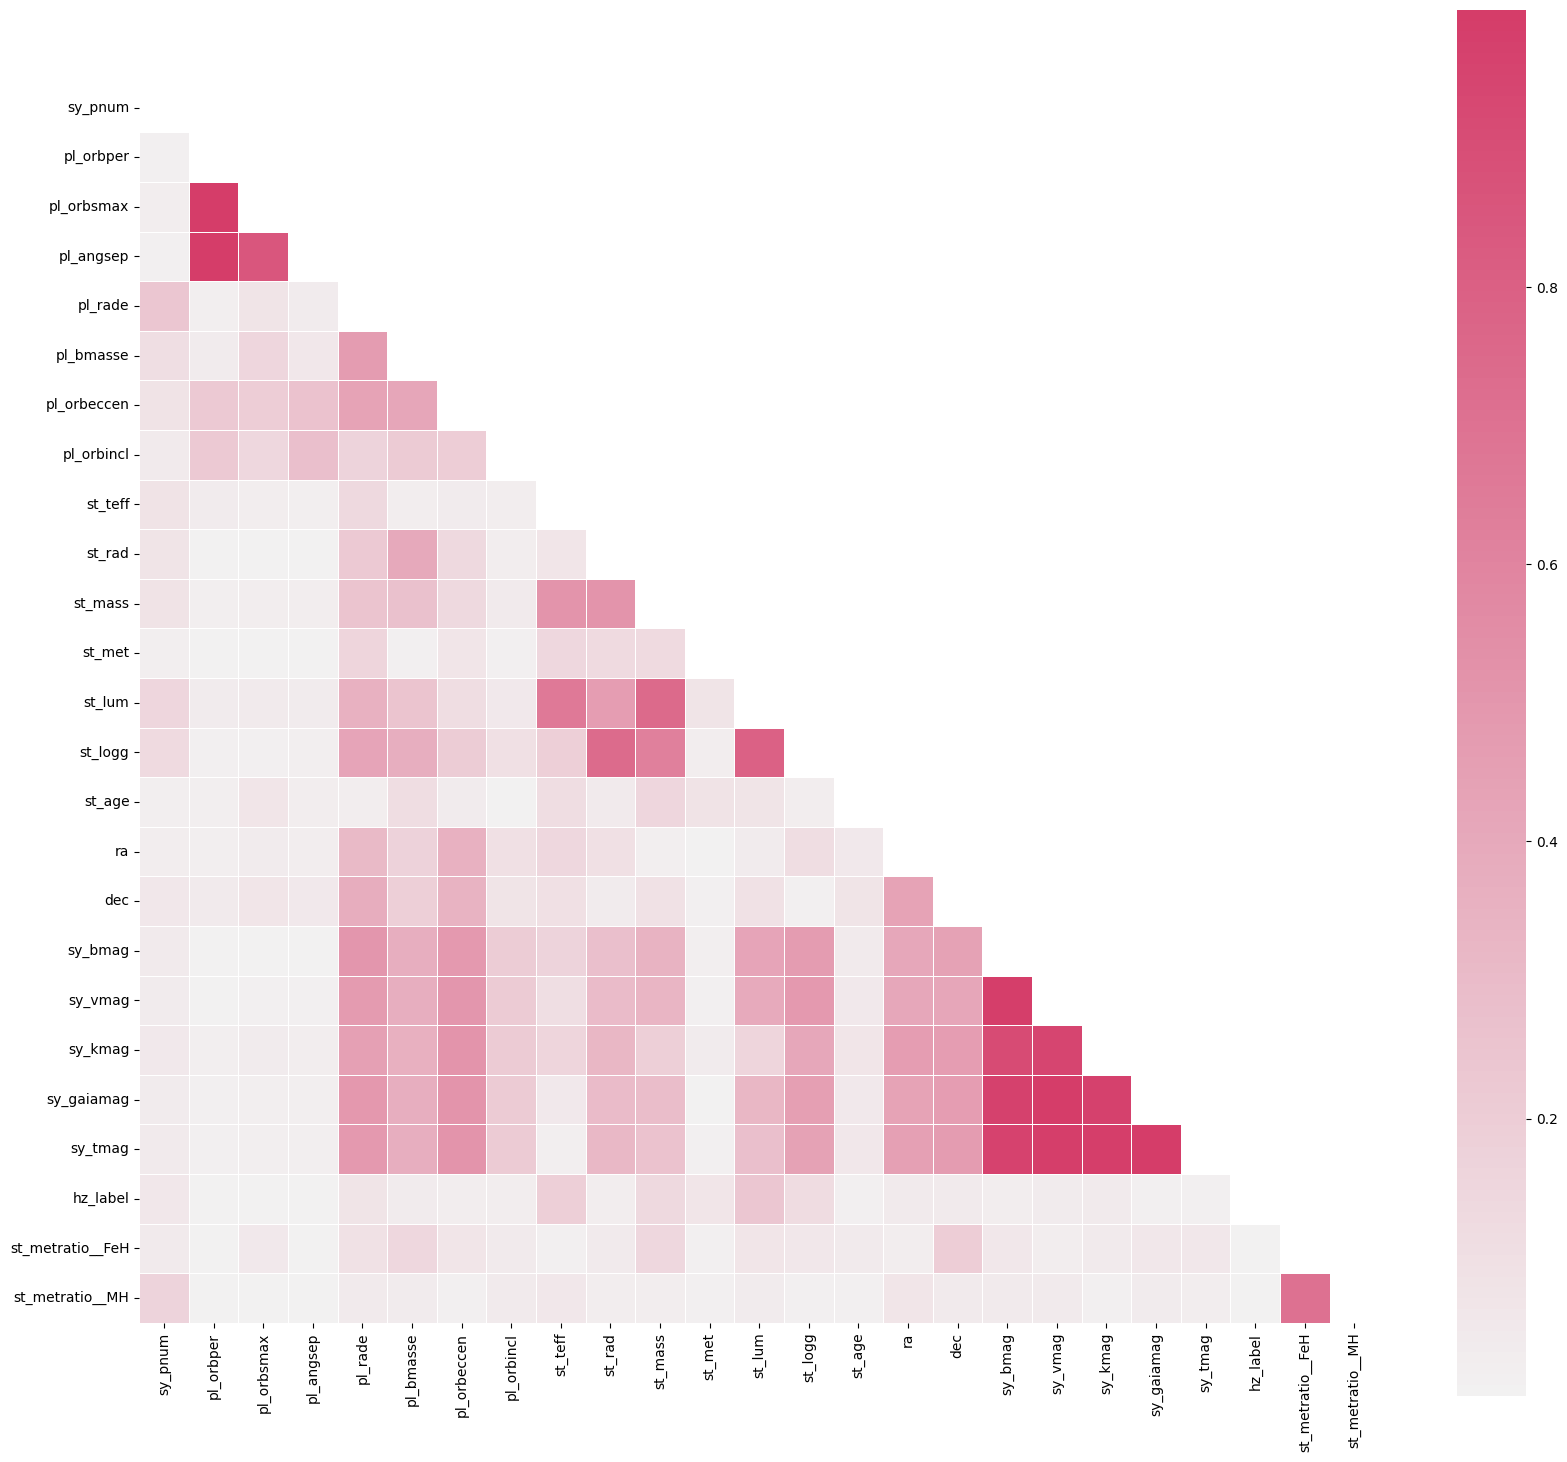

In [ ]:
correlation_matrix = features.corr().abs()

mask = np.triu(np.ones_like(correlation_matrix, dtype = np.bool_))
f, ax = plt.subplots(figsize = (20, 20))
cmap = sns.diverging_palette(255, 0, as_cmap = True)
sns.heatmap(correlation_matrix,
            mask = mask,
            cmap = cmap,
            vmax = None,
            center = 0,
            square = True,
            annot = False,
            linewidths = .5,
            cbar_kws = {"shrink": 0.9})

In [ ]:
# Drop highly correlated data fields
features = features.drop(['pl_orbper',
                          'pl_angsep',
                          'st_lum',
                          'st_logg',
                          'sy_bmag',
                          'sy_vmag',
                          'sy_gaiamag',
                          'sy_tmag'
                          ],
                          axis = 1)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sy_pnum           5044 non-null   int64  
 1   pl_orbsmax        4796 non-null   float64
 2   pl_rade           5032 non-null   float64
 3   pl_bmasse         5020 non-null   float64
 4   pl_orbeccen       4348 non-null   float64
 5   pl_orbincl        3944 non-null   float64
 6   st_teff           4840 non-null   float64
 7   st_rad            4832 non-null   float64
 8   st_mass           5043 non-null   float64
 9   st_met            4674 non-null   float64
 10  st_age            4014 non-null   float64
 11  ra                5044 non-null   float64
 12  dec               5044 non-null   float64
 13  sy_kmag           4844 non-null   float64
 14  hz_label          5044 non-null   float64
 15  st_metratio__FeH  5044 non-null   bool   
 16  st_metratio__MH   5044 non-null   bool   


In [ ]:
def plot_confusion_matrix(labels, predictions):
    # Create a confusion matrix that compares the prediction results against the labels
    confusionMatrix = confusion_matrix(labels, predictions)

    # Create a dataframe for the confusion matrix for plotting
    confusionMatrixDf = pd.DataFrame(confusionMatrix,
                                     index = ['Non-Habitable', 'Habitable'],
                                     columns = ['Non-Habitable', 'Habitable'])

    # Plot the confusion matrix
    plt.figure(figsize = (5,4))
    sns.heatmap(confusionMatrixDf, annot = True)
    plt.title('Habitability Confusion Matrix')
    plt.ylabel('Label Values')
    plt.xlabel('Predicted Values')
    plt.show()

    return confusionMatrix

In [ ]:
from typing import Any
def search_optimal_params_random_forest(features,
                                        labels,
                                        cross_validation_rounds,
                                        split_test_size,
                                        split_stratify,
                                        split_random_state):
    print(f"Searching the optimal hyper parameters for Random Forest classifier...\n")

    best_avg_precision = 0
    best_precision_within_hyper_parameters_config = 0

    optimal_n_estimators = 1
    optimal_criterion = 'gini'
    optimal_max_depth = 1
    optimal_max_features = 'log2'
    optimal_max_leaf_nodes = 1
    optimal_min_samples_leaf = 1
    optimal_min_samples_split = 1

    optimal_rf_model_within_hyper_parameters_config = RandomForestClassifier()
    optimal_feature_train_within_hyper_parameters_config = features
    optimal_labels_train_within_hyper_parameters_config = labels
    optimal_feature_test_within_hyper_parameters_config = features
    optimal_labels_test_within_hyper_parameters_config = labels
    optimal_imputer_within_hyper_parameters_config = mf.ImputationKernel(features)
    optimal_minMaxScaler_within_hyper_parameters_config = MinMaxScaler()

    optimal_rf_model = optimal_rf_model_within_hyper_parameters_config
    optimal_feature_train = optimal_feature_train_within_hyper_parameters_config
    optimal_labels_train = optimal_labels_train_within_hyper_parameters_config
    optimal_feature_test = optimal_feature_test_within_hyper_parameters_config
    optimal_labels_test = optimal_labels_test_within_hyper_parameters_config
    optimal_imputer = optimal_imputer_within_hyper_parameters_config
    optimal_minMaxScaler = optimal_minMaxScaler_within_hyper_parameters_config

    #for n_estimators in [100, 37, 65]:
    for n_estimators in [10, 12, 15, 20, 25, 30, 37, 40, 45, 50, 60, 70, 80, 100, 120, 150, 180, 200, 300]:
        print(f"Iterate through {n_estimators} estimators...\n")
        #for criterion in ['gini', 'entropy', 'log_loss']:
        for criterion in ['entropy']:
            print(f"Iterate through {criterion}...\n")
            #for min_samples_leaf in [1, 2, 3, 4, 5]:
            for min_samples_leaf in [1]:
              #for min_samples_split in [2, 4, 6, 8, 10]:
              for min_samples_split in [2]:
                #for max_depth in range(4, 12, 1):
                #for max_depth in [10, 15, 20, 30]:
                for max_depth in [10]:
                  #for max_features in ['log2', 'sqrt']:
                  for max_features in ['log2']:
                    print(f"Iterate through {max_features}...\n")
                    #for max_leaf_nodes in range(5, 12, 1):
                    #for max_leaf_nodes in [10, 20, 30]:
                    for max_leaf_nodes in [10]:
                        best_precision_within_hyper_parameters_config = 0

                        accuracy_sum = 0
                        precision_sum = 0
                        recall_sum = 0
                        f1_sum = 0
                        for round in range(cross_validation_rounds):
                            features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                                        labels,
                                                                                                        test_size=split_test_size,
                                                                                                        stratify=split_stratify,
                                                                                                        random_state=split_random_state,
                                                                                                        shuffle=True)

                            # Fill in the missing values for the numeric data fields with Multivariate Imputation by Chained Equation (MICE) imputation
                            # https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00313-w
                            features_train = features_train.reset_index(drop=True)
                            imputationKernel = mf.ImputationKernel(
                                features_train,
                                save_all_iterations_data=True,
                                random_state=1991)
                            imputationKernel.mice(iterations=5)
                            imputed_features_train = imputationKernel.complete_data()

                            features_test = features_test.reset_index(drop=True)
                            kds_features_test = imputationKernel.impute_new_data(features_test)
                            imputed_features_test = kds_features_test.complete_data()
                            imputed_features_test = imputed_features_test.dropna()

                            # Apply SMOTE-ENN for oversample and downsample to balance training datasets
                            features_to_balance, labels_to_balance = imputed_features_train.drop(['hz_label'], axis = 1), imputed_features_train.hz_label
                            smoteenn = SMOTEENN(sampling_strategy=0.5, random_state=0)
                            balanced_features, balanced_labels = smoteenn.fit_resample(features_to_balance, labels_to_balance)

                            balanced_feature_train = balanced_features
                            balanced_feature_train['hz_label'] = balanced_labels
                            features_train = balanced_feature_train.drop('hz_label', axis = 1)
                            labels_train = balanced_feature_train['hz_label']

                            features_test = imputed_features_test.drop('hz_label', axis = 1)

                            # Apply minMaxScaler
                            minMaxScaler = MinMaxScaler()
                            minMaxScaler.fit(features_train)
                            features_train = minMaxScaler.transform(features_train)
                            features_test = minMaxScaler.transform(features_test)

                            # Train Radmon Forest classifier
                            rfc = RandomForestClassifier(n_estimators=n_estimators,
                                                         criterion=criterion,
                                                         max_depth=max_depth,
                                                         max_features=max_features,
                                                         max_leaf_nodes=max_leaf_nodes,
                                                         min_samples_leaf=min_samples_leaf,
                                                         min_samples_split=min_samples_split,
                                                         class_weight='balanced',
                                                         random_state=0)
                            rfc.fit(features_train, labels_train)

                            # Predict the samples in the test subset
                            rfc_predictions = rfc.predict(features_test)

                            # Calculate the metrics for Random Forest classifier
                            rfc_accuracy = accuracy_score(labels_test, rfc_predictions)
                            rfc_precision = precision_score(labels_test, rfc_predictions)
                            rfc_recall = recall_score(labels_test, rfc_predictions)
                            rfc_f1 = f1_score(labels_test, rfc_predictions)

                            if rfc_precision > best_precision_within_hyper_parameters_config:
                                best_precision_within_hyper_parameters_config = rfc_precision
                                optimal_rf_model_within_hyper_parameters_config = rfc
                                optimal_feature_train_within_hyper_parameters_config = features_train
                                optimal_labels_train_within_hyper_parameters_config = labels_train
                                optimal_feature_test_within_hyper_parameters_config = features_test
                                optimal_labels_test_within_hyper_parameters_config = labels_test
                                optimal_imputer_within_hyper_parameters_config = imputationKernel
                                optimal_minMaxScaler_within_hyper_parameters_config = minMaxScaler

                            accuracy_sum += rfc_accuracy
                            precision_sum += rfc_precision
                            recall_sum += rfc_recall
                            f1_sum += rfc_f1

                        avg_accuracy = accuracy_sum / cross_validation_rounds
                        avg_precision = precision_sum / cross_validation_rounds
                        avg_recall = recall_sum / cross_validation_rounds
                        avg_f1 = f1_sum / cross_validation_rounds

                        if avg_precision > best_avg_precision:
                             best_avg_precision = avg_precision
                             optimal_n_estimators = n_estimators
                             optimal_criterion = criterion,
                             optimal_max_depth = max_depth,
                             optimal_max_features = max_features,
                             optimal_max_leaf_nodes = max_leaf_nodes
                             optimal_min_samples_leaf = min_samples_leaf
                             optimal_min_samples_split = min_samples_split

                             optimal_rf_model = optimal_rf_model_within_hyper_parameters_config
                             optimal_feature_train = optimal_feature_train_within_hyper_parameters_config
                             optimal_labels_train = optimal_labels_train_within_hyper_parameters_config
                             optimal_feature_test = optimal_feature_test_within_hyper_parameters_config
                             optimal_labels_test = optimal_labels_test_within_hyper_parameters_config
                             optimal_imputer = optimal_imputer_within_hyper_parameters_config
                             optimal_minMaxScaler = optimal_minMaxScaler_within_hyper_parameters_config

                             # Save the Random Forest classifier model
                             random_forest_pickle = open('/content/drive/My Drive/Colab Notebooks/research/JPL/ExoplanetHabitability/random_forest_classifier', 'wb')
                             pickle.dump(rfc, random_forest_pickle)
                             random_forest_pickle.close()

                             print(f"Found a better avg_precision: {best_avg_precision} with (avg_recall: {avg_recall}, avg_f1: {avg_f1}, and avg_accuracy: {avg_accuracy}")
                             print(f"Hyperparameters - n_estimators: {optimal_n_estimators}, criterion: {optimal_criterion}, max_features: {optimal_max_features},")
                             print(f"                  max_depth: {optimal_max_depth}, max_leaf_nodes: {optimal_max_leaf_nodes},")
                             print(f"                  min_samples_leaf: {optimal_min_samples_leaf}, min_samples_split: {optimal_min_samples_split}\n")

    print(f"The hyperparameters for the model with best avg_precision {best_avg_precision} are:\n")
    print(f" n_estimators: {optimal_n_estimators}\n criterion: {optimal_criterion}\n max_features: {optimal_max_features}\n max_depth: {optimal_max_depth}\n max_leaf_nodes: {optimal_max_leaf_nodes}\n min_samples_leaf: {optimal_min_samples_leaf}\n min_samples_split: {optimal_min_samples_split}\n")
    return optimal_rf_model, optimal_feature_train, optimal_labels_train, optimal_feature_test, optimal_labels_test, optimal_imputer, optimal_minMaxScaler

# Run exhausitive search to find the optimal hyper parameter settings
optimal_rf_model, feature_train_for_optimal_model, labels_train_for_optimal_model, feature_test_for_optimal_model, labels_test_for_optimal_model, imputer_for_optimal_model, minMaxScaler_for_optimal_model = search_optimal_params_random_forest(
    features=features,
    labels=labels,
    cross_validation_rounds=100,
    split_test_size=0.45,
    split_stratify=labels,
    split_random_state=42)

Searching the optimal hyper parameters for Random Forest classifier...

Iterate through 10 estimators...

Iterate through entropy...

Iterate through log2...

Found a better avg_precision: 0.8028169014084507 with (avg_recall: 0.926829268292683, avg_f1: 0.8603773584905661, and avg_accuracy: 0.9827425373134329
Hyperparameters - n_estimators: 10, criterion: ('entropy',), max_features: ('log2',),
                  max_depth: (10,), max_leaf_nodes: 10,
                  min_samples_leaf: 1, min_samples_split: 2

Iterate through 12 estimators...

Iterate through entropy...

Iterate through log2...

Found a better avg_precision: 0.8432835820895522 with (avg_recall: 0.9186991869918699, avg_f1: 0.8793774319066148, and avg_accuracy: 0.9855410447761194
Hyperparameters - n_estimators: 12, criterion: ('entropy',), max_features: ('log2',),
                  max_depth: (10,), max_leaf_nodes: 10,
                  min_samples_leaf: 1, min_samples_split: 2

Iterate through 15 estimators...

Iterate thr

In [ ]:
from typing import Any
def search_optimal_params_random_forest(features,
                                        labels,
                                        cross_validation_rounds,
                                        split_test_size,
                                        split_stratify,
                                        split_random_state):
    print(f"Searching the optimal hyper parameters for Random Forest classifier...\n")

    best_avg_precision = 0
    best_precision_within_hyper_parameters_config = 0
    best_avg_f1 = 0
    best_f1_within_hyper_parameters_config = 0

    optimal_n_estimators = 1
    optimal_criterion = 'gini'
    optimal_max_depth = 1
    optimal_max_features = 'log2'
    optimal_max_leaf_nodes = 1
    optimal_min_samples_leaf = 1
    optimal_min_samples_split = 1

    optimal_rf_model_within_hyper_parameters_config = RandomForestClassifier()
    optimal_feature_train_within_hyper_parameters_config = features
    optimal_labels_train_within_hyper_parameters_config = labels
    optimal_feature_test_within_hyper_parameters_config = features
    optimal_labels_test_within_hyper_parameters_config = labels
    optimal_imputer_within_hyper_parameters_config = mf.ImputationKernel(features)
    optimal_minMaxScaler_within_hyper_parameters_config = MinMaxScaler()

    optimal_rf_model = optimal_rf_model_within_hyper_parameters_config
    optimal_feature_train = optimal_feature_train_within_hyper_parameters_config
    optimal_labels_train = optimal_labels_train_within_hyper_parameters_config
    optimal_feature_test = optimal_feature_test_within_hyper_parameters_config
    optimal_labels_test = optimal_labels_test_within_hyper_parameters_config
    optimal_imputer = optimal_imputer_within_hyper_parameters_config
    optimal_minMaxScaler = optimal_minMaxScaler_within_hyper_parameters_config

    #for n_estimators in [100, 37, 65]:
    for n_estimators in [100]:
        print(f"Iterate through {n_estimators} estimators...\n")
        #for criterion in ['gini', 'entropy', 'log_loss']:
        for criterion in ['entropy']:
            print(f"Iterate through {criterion}...\n")
            for min_samples_leaf in [1, 2, 3, 4, 5]:
            #for min_samples_leaf in [1]:
              for min_samples_split in [2, 4, 6, 8, 10]:
              #for min_samples_split in [2]:
                #for max_depth in range(4, 12, 1):
                for max_depth in [10, 15, 20, 25, 30, 40, 50]:
                #for max_depth in [10]:
                  #for max_features in ['log2', 'sqrt']:
                  for max_features in ['log2']:
                    print(f"Iterate through {max_features}...\n")
                    #for max_leaf_nodes in range(5, 12, 1):
                    for max_leaf_nodes in [10, 12, 15, 17, 20, 25, 30, 40, 50]:
                    #for max_leaf_nodes in [10]:
                        best_precision_within_hyper_parameters_config = 0

                        accuracy_sum = 0
                        precision_sum = 0
                        recall_sum = 0
                        f1_sum = 0
                        for round in range(cross_validation_rounds):
                            features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                                        labels,
                                                                                                        test_size=split_test_size,
                                                                                                        stratify=split_stratify,
                                                                                                        random_state=split_random_state,
                                                                                                        shuffle=True)

                            # Fill in the missing values for the numeric data fields with Multivariate Imputation by Chained Equation (MICE) imputation
                            # https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00313-w
                            features_train = features_train.reset_index(drop=True)
                            imputationKernel = mf.ImputationKernel(
                                features_train,
                                save_all_iterations_data=True,
                                random_state=1991)
                            imputationKernel.mice(iterations=5)
                            imputed_features_train = imputationKernel.complete_data()

                            features_test = features_test.reset_index(drop=True)
                            kds_features_test = imputationKernel.impute_new_data(features_test)
                            imputed_features_test = kds_features_test.complete_data()
                            imputed_features_test = imputed_features_test.dropna()

                            # Apply SMOTE-ENN for oversample and downsample to balance training datasets
                            features_to_balance, labels_to_balance = imputed_features_train.drop(['hz_label'], axis = 1), imputed_features_train.hz_label
                            smoteenn = SMOTEENN(sampling_strategy=0.5, random_state=0)
                            balanced_features, balanced_labels = smoteenn.fit_resample(features_to_balance, labels_to_balance)

                            balanced_feature_train = balanced_features
                            balanced_feature_train['hz_label'] = balanced_labels
                            features_train = balanced_feature_train.drop('hz_label', axis = 1)
                            labels_train = balanced_feature_train['hz_label']

                            features_test = imputed_features_test.drop('hz_label', axis = 1)

                            # Apply minMaxScaler
                            minMaxScaler = MinMaxScaler()
                            minMaxScaler.fit(features_train)
                            features_train = minMaxScaler.transform(features_train)
                            features_test = minMaxScaler.transform(features_test)

                            # Train Radmon Forest classifier
                            rfc = RandomForestClassifier(n_estimators=n_estimators,
                                                         criterion=criterion,
                                                         max_depth=max_depth,
                                                         max_features=max_features,
                                                         max_leaf_nodes=max_leaf_nodes,
                                                         min_samples_leaf=min_samples_leaf,
                                                         min_samples_split=min_samples_split,
                                                         class_weight='balanced',
                                                         random_state=0)
                            rfc.fit(features_train, labels_train)

                            # Predict the samples in the test subset
                            rfc_predictions = rfc.predict(features_test)

                            # Plot the confusion matrix and print out the classification evaluation report
                            rfc_accuracy = accuracy_score(labels_test, rfc_predictions)
                            rfc_precision = precision_score(labels_test, rfc_predictions)
                            rfc_recall = recall_score(labels_test, rfc_predictions)
                            rfc_f1 = f1_score(labels_test, rfc_predictions)

                            #if rfc_precision > best_precision_within_hyper_parameters_config:
                            if rfc_f1 > best_f1_within_hyper_parameters_config:
                                #best_precision_within_hyper_parameters_config = rfc_precision
                                best_f1_within_hyper_parameters_config = rfc_f1
                                optimal_rf_model_within_hyper_parameters_config = rfc
                                optimal_feature_train_within_hyper_parameters_config = features_train
                                optimal_labels_train_within_hyper_parameters_config = labels_train
                                optimal_feature_test_within_hyper_parameters_config = features_test
                                optimal_labels_test_within_hyper_parameters_config = labels_test
                                optimal_imputer_within_hyper_parameters_config = imputationKernel
                                optimal_minMaxScaler_within_hyper_parameters_config = minMaxScaler

                            accuracy_sum += rfc_accuracy
                            precision_sum += rfc_precision
                            recall_sum += rfc_recall
                            f1_sum += rfc_f1

                        avg_accuracy = accuracy_sum / cross_validation_rounds
                        avg_precision = precision_sum / cross_validation_rounds
                        avg_recall = recall_sum / cross_validation_rounds
                        avg_f1 = f1_sum / cross_validation_rounds

                        #if avg_precision > best_avg_precision:
                        if avg_f1 > best_avg_f1:
                             #best_avg_precision = avg_precision
                             best_avg_f1 = avg_f1
                             optimal_n_estimators = n_estimators
                             optimal_criterion = criterion,
                             optimal_max_depth = max_depth,
                             optimal_max_features = max_features,
                             optimal_max_leaf_nodes = max_leaf_nodes
                             optimal_min_samples_leaf = min_samples_leaf
                             optimal_min_samples_split = min_samples_split

                             optimal_rf_model = optimal_rf_model_within_hyper_parameters_config
                             optimal_feature_train = optimal_feature_train_within_hyper_parameters_config
                             optimal_labels_train = optimal_labels_train_within_hyper_parameters_config
                             optimal_feature_test = optimal_feature_test_within_hyper_parameters_config
                             optimal_labels_test = optimal_labels_test_within_hyper_parameters_config
                             optimal_imputer = optimal_imputer_within_hyper_parameters_config
                             optimal_minMaxScaler = optimal_minMaxScaler_within_hyper_parameters_config

                             # Save the Random Forest classifier model
                             random_forest_pickle = open('/content/drive/My Drive/Colab Notebooks/research/JPL/ExoplanetHabitability/random_forest_classifier', 'wb')
                             pickle.dump(rfc, random_forest_pickle)
                             random_forest_pickle.close()

                             #print(f"Found a better avg_precision: {best_avg_precision} with (avg_recall: {avg_recall}, avg_f1: {avg_f1}, and avg_accuracy: {avg_accuracy}")
                             print(f"Found a better avg_f1: {best_avg_f1} with avg_precision: {avg_precision}, avg_recall: {avg_recall}, and avg_accuracy: {avg_accuracy}")
                             print(f"Hyperparameters - n_estimators: {optimal_n_estimators}, criterion: {optimal_criterion}, max_features: {optimal_max_features},")
                             print(f"                  max_depth: {optimal_max_depth}, max_leaf_nodes: {optimal_max_leaf_nodes},")
                             print(f"                  min_samples_leaf: {optimal_min_samples_leaf}, min_samples_split: {optimal_min_samples_split}\n")

    #print(f"The hyperparameters for the model with best avg_precision {best_avg_precision} are:\n")
    print(f"The hyperparameters for the model with best avg_f1 {best_avg_f1} are:\n")
    print(f" n_estimators: {optimal_n_estimators}\n criterion: {optimal_criterion}\n max_features: {optimal_max_features}\n max_depth: {optimal_max_depth}\n max_leaf_nodes: {optimal_max_leaf_nodes}\n min_samples_leaf: {optimal_min_samples_leaf}\n min_samples_split: {optimal_min_samples_split}\n")
    return optimal_rf_model, optimal_feature_train, optimal_labels_train, optimal_feature_test, optimal_labels_test, optimal_imputer, optimal_minMaxScaler

# Run exhausitive search to find the optimal hyper parameter settings
optimal_rf_model, feature_train_for_optimal_model, labels_train_for_optimal_model, feature_test_for_optimal_model, labels_test_for_optimal_model, imputer_for_optimal_model, minMaxScaler_for_optimal_model = search_optimal_params_random_forest(
    features=features,
    labels=labels,
    cross_validation_rounds=100,
    split_test_size=0.45,
    split_stratify=labels,
    split_random_state=42)

Searching the optimal hyper parameters for Random Forest classifier...

Iterate through 100 estimators...

Iterate through entropy...

Iterate through log2...

Found a better avg_f1: 0.9212598425196851 with avg_precision: 0.8931297709923665, avg_recall: 0.9512195121951219, and avg_accuracy: 0.9906716417910447
Hyperparameters - n_estimators: 100, criterion: ('entropy',), max_features: ('log2',),
                  max_depth: (10,), max_leaf_nodes: 10,
                  min_samples_leaf: 1, min_samples_split: 2

Found a better avg_f1: 0.9354838709677419 with avg_precision: 0.928, avg_recall: 0.943089430894309, and avg_accuracy: 0.9925373134328358
Hyperparameters - n_estimators: 100, criterion: ('entropy',), max_features: ('log2',),
                  max_depth: (10,), max_leaf_nodes: 15,
                  min_samples_leaf: 1, min_samples_split: 2

Iterate through log2...

Found a better avg_f1: 0.9392712550607287 with avg_precision: 0.9354838709677419, avg_recall: 0.943089430894309, and av

In [ ]:
# Run optimal Random Forest classifier on test data
pred_results = optimal_rf_model.predict(feature_test_for_optimal_model)

# Print out the index for the postive prediction
print(f"The index of postive prediction in test dataset:")
for i in range(1, 2144, 1):
    if pred_results[i] > 0:
       print(f"{i}")

The index of postive prediction in test dataset:
542
786
1130
1196
1657
1783
2021
2022
2024
2025
2026
2027
2028
2029
2030
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2047
2048
2049
2050
2051
2052
2053
2054
2055
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143


Feature Importance
st_teff: Stellar Effective Temperature [K]                    0.257404
st_rad: Stellar Radius [Solar Radius]                         0.237881
st_mass: Stellar Mass [Solar mass]                            0.142617
pl_rade: Planet Radius [Earth Radius]                         0.107371
pl_orbsmax: Planet Orbit Semi-Major Axis [au]                 0.087941
pl_bmasse: Planet Mass or Mass*sin(i) [Earth Mass]            0.046244
st_met: Stellar Metallicity [dex]                             0.037951
pl_orbeccen: Planet Orbit Eccentricity                        0.016574
dec: Declination of the Planetary System [decimal]            0.016408
pl_orbincl: Planet Inclination [deg]                          0.012789
ra: Right Ascension of the Planetary System [de...            0.011394
st_age: Stellar Age [Gyr]                                     0.009847
sy_kmag: Stellar Ks (2MASS) Magnitude                         0.007539
st_metratio__[Fe/H]: Stellar Metallicity Ratio                0.005444
sy_pnum: Number of Planets in the Planetary System            0.002473
st_metratio__[M/H]: Stellar Metallicity Ratio                 0.000122

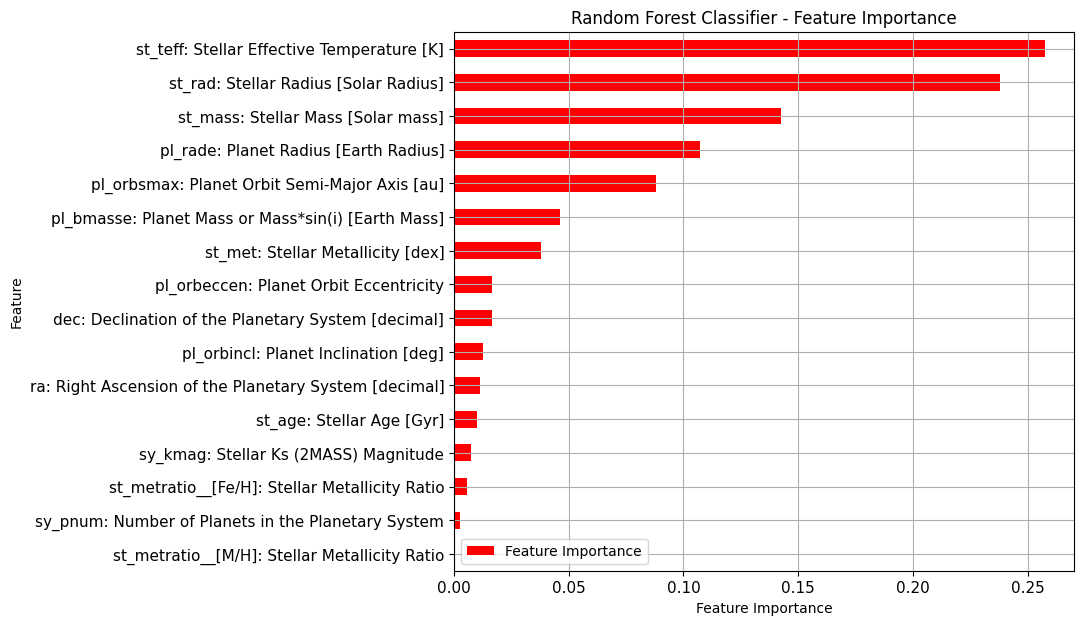

In [ ]:
# Calculate and plot feature importance
feature_importances = pd.DataFrame(data=optimal_rf_model.feature_importances_,
                                   index=feature_columns,
                                   columns=["Feature Importance"])
cmap = cm.get_cmap('hsv')

feature_importances.sort_values(by='Feature Importance', ascending=True, inplace=True)
feature_importances.plot(kind='barh',
                         figsize=(8,7),
                         title='Random Forest Classifier - Feature Importance',
                         xlabel='Feature Importance',
                         ylabel='Feature',
                         fontsize=11,
                         cmap=cmap,
                         grid=True)

feature_importances.sort_values(by='Feature Importance', ascending=False, inplace=True)
feature_importances

PermutationExplainer explainer: 2145it [05:55,  5.92it/s]


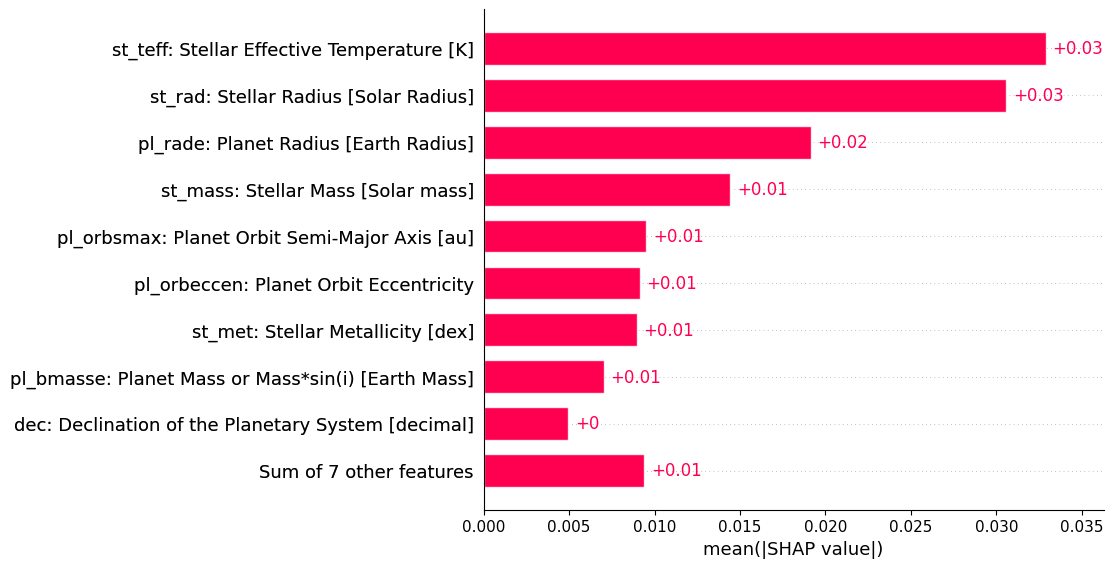

In [ ]:
rfc_explainer = shap.Explainer(optimal_rf_model.predict, feature_test_for_optimal_model, feature_names=feature_columns)
rfc_shap_values = rfc_explainer(feature_test_for_optimal_model)
shap.plots.bar(rfc_shap_values)

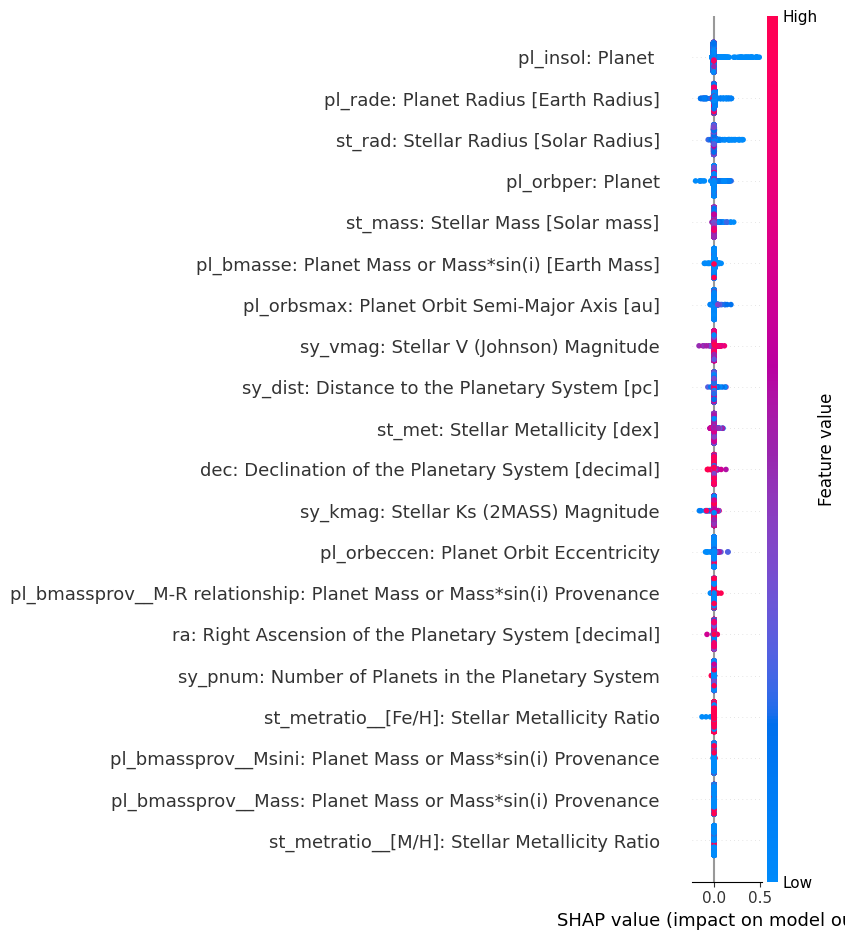

In [ ]:
shap.summary_plot(rfc_shap_values, feature_test_for_optimal_model, feature_names=feature_columns)

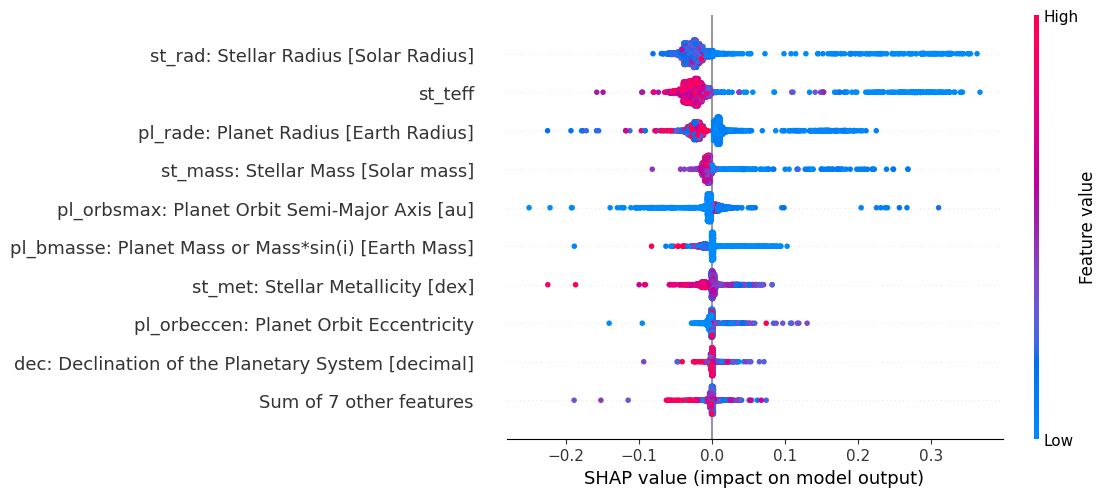

In [ ]:
shap.plots.beeswarm(rfc_shap_values)

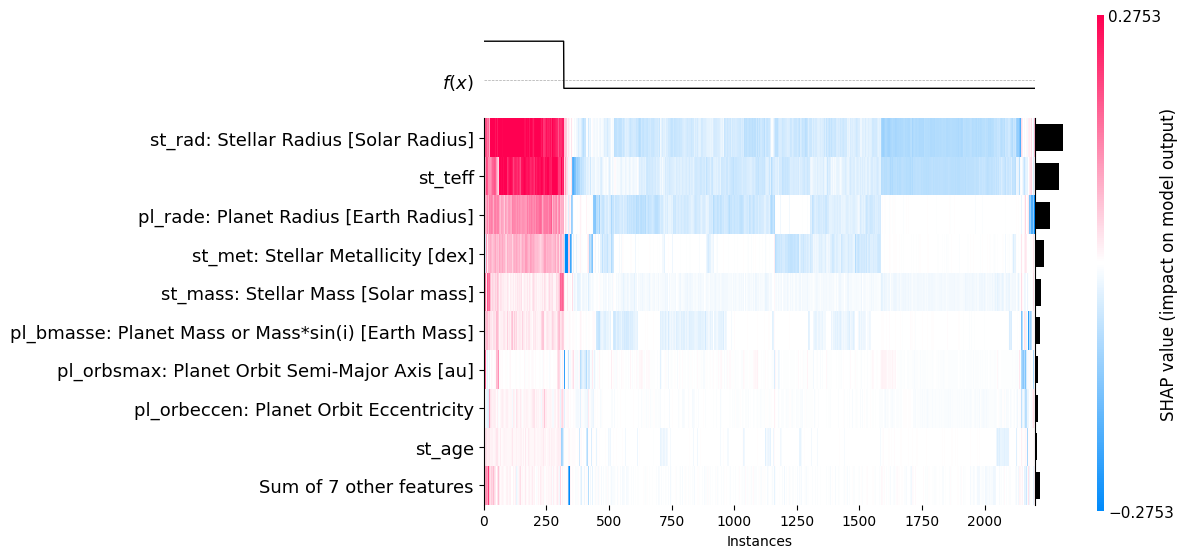

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(rfc_shap_values[:2144])

In [ ]:
shap.initjs()
shap.plots.force(rfc_shap_values[:2144])

In [ ]:
shap.initjs()
shap.plots.force(rfc_shap_values[0])

In [ ]:
shap.initjs()
shap.plots.force(rfc_shap_values[542])

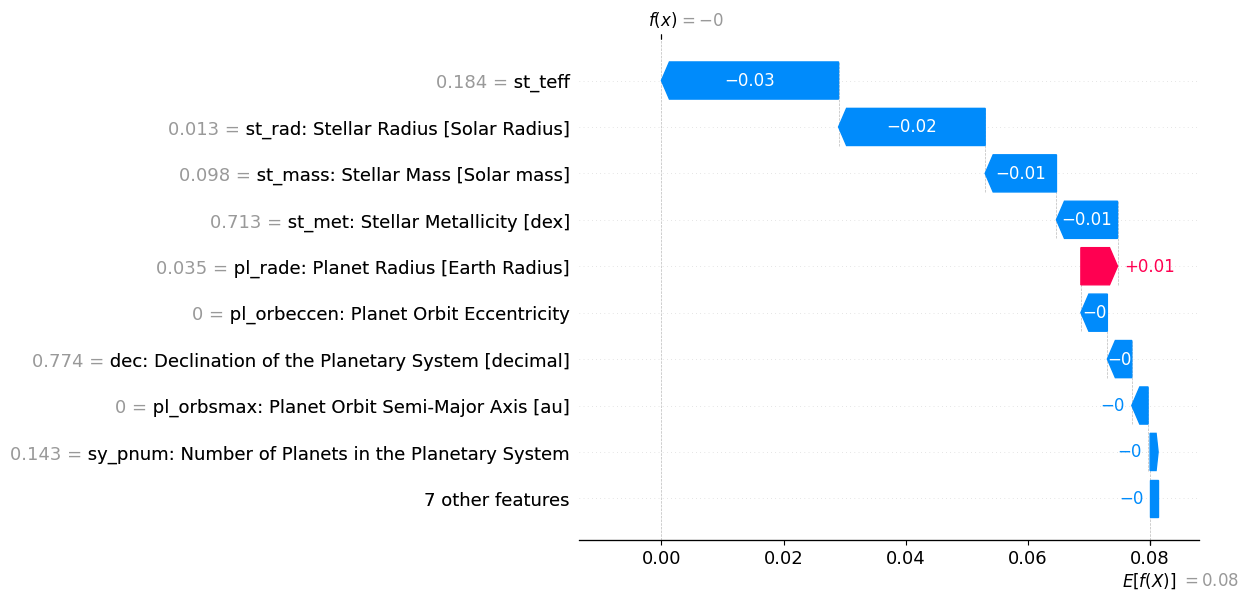

In [ ]:
shap.plots.waterfall(rfc_shap_values[0])

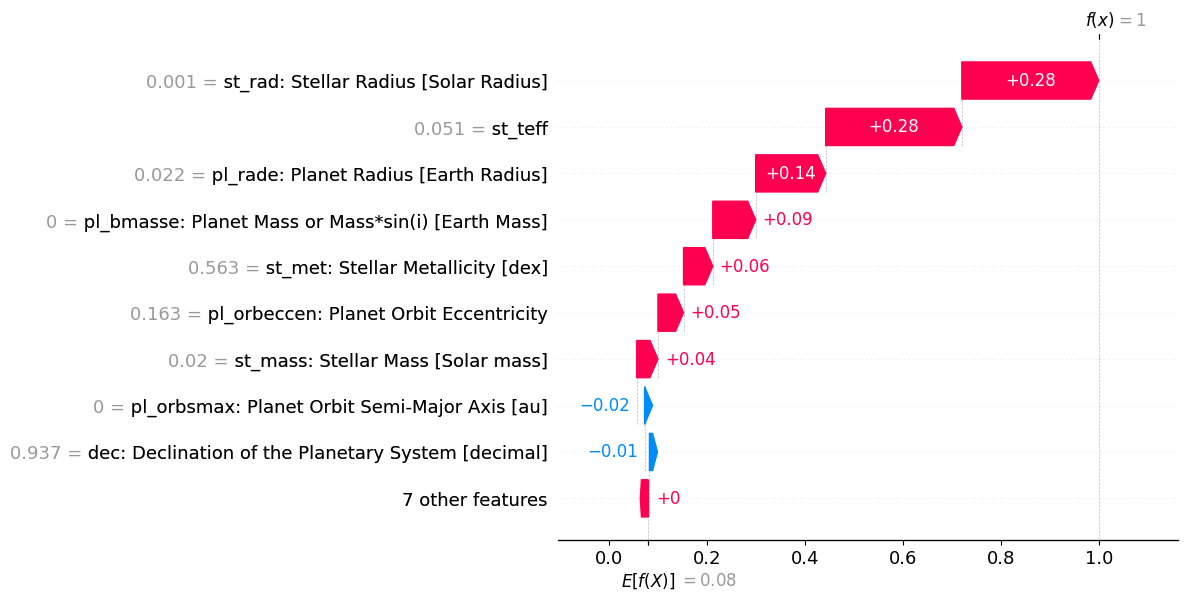

In [ ]:
shap.plots.waterfall(rfc_shap_values[542])

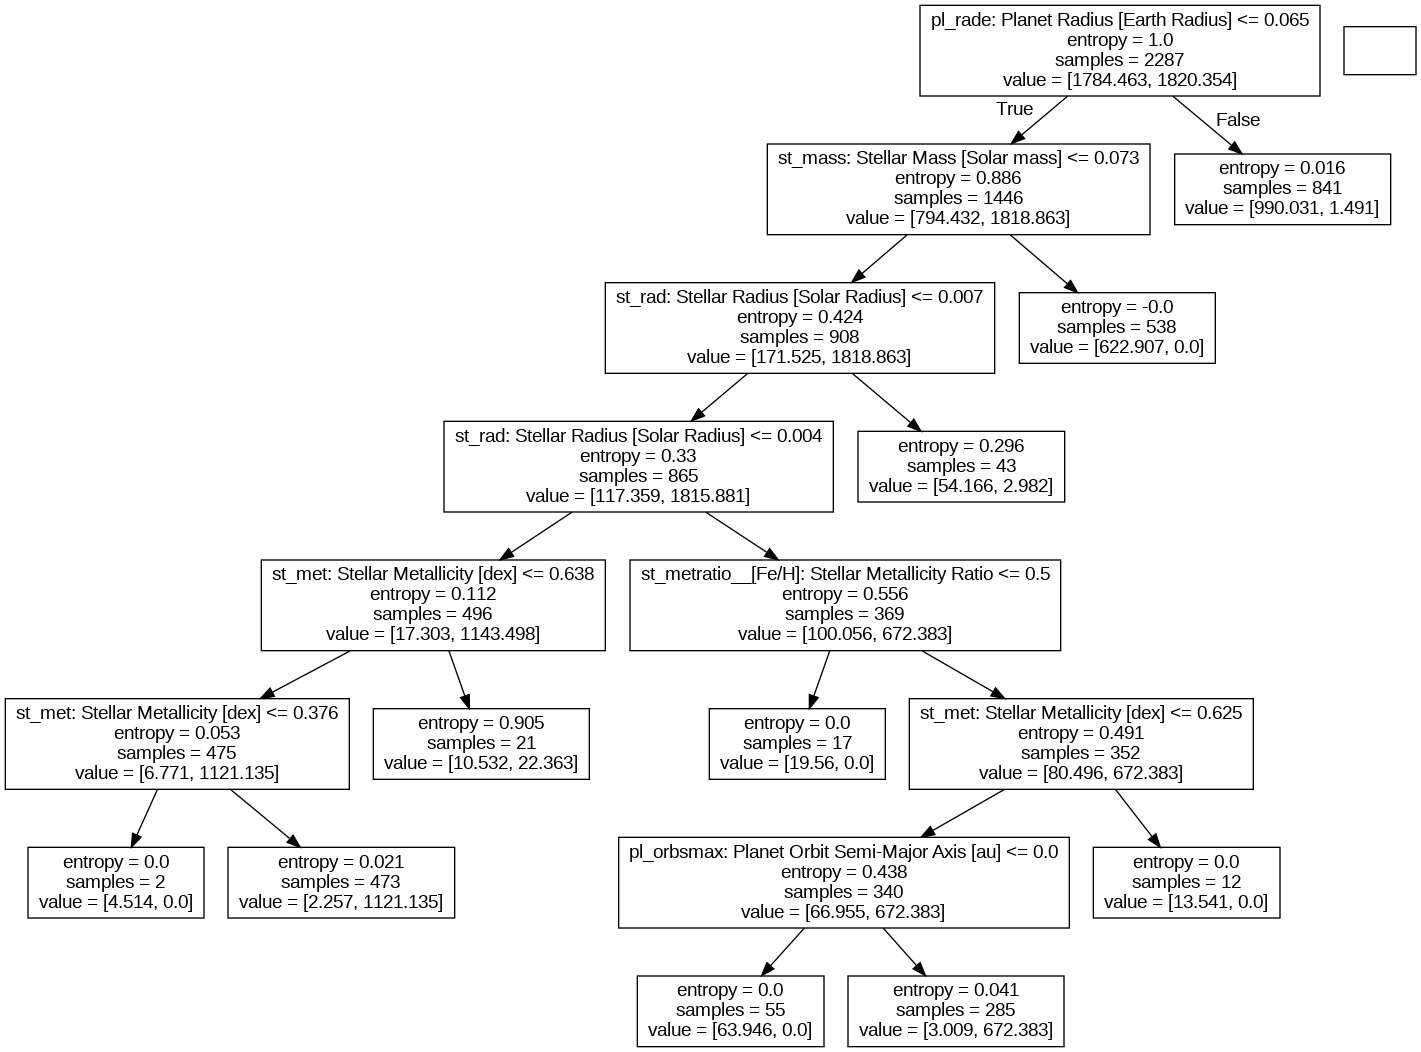

In [ ]:
dot_data = StringIO()
export_graphviz(optimal_rf_model.estimators_[3],
                feature_names=feature_columns,
                out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

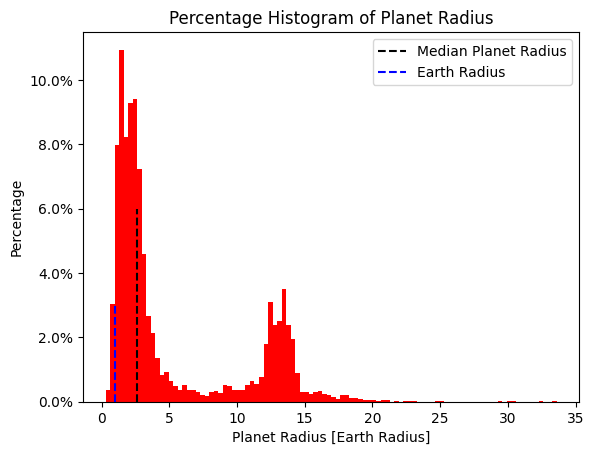

count    5032.000000
mean        5.339733
std         5.066838
min         0.309800
25%         1.740000
50%         2.670000
75%        10.099469
90%        13.500000
95%        14.100000
99%        18.020700
99.5%      19.249911
99.9%      24.989460
max        33.600000
Name: pl_rade, dtype: float64

In [ ]:
hist_data = features['pl_rade']
plt.hist(hist_data,
         bins=100,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='red')
plt.vlines(x=2.65, ymin=0, ymax=0.06, colors='black', linestyles='dashed', label='Median Planet Radius')
plt.vlines(x=1, ymin=0, ymax=0.03, colors='blue', linestyles='dashed', label='Earth Radius')
plt.title("Percentage Histogram of Planet Radius")
plt.xlabel("Planet Radius [Earth Radius]")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features['pl_rade'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

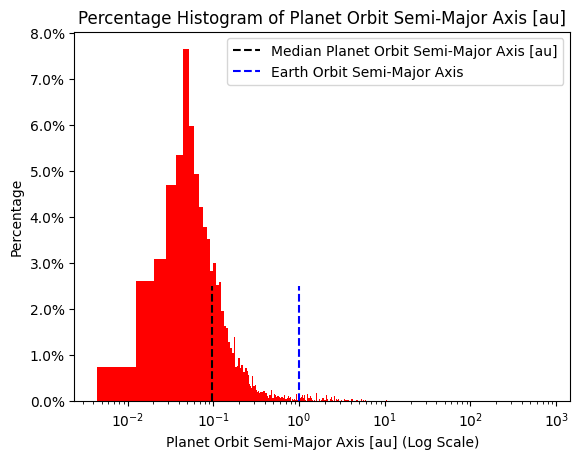

count    4790.000000
mean        2.423822
std        28.773069
min         0.004400
25%         0.053630
50%         0.102000
75%         0.267923
90%         1.700000
95%         3.395550
99%        16.776290
99.5%      92.104500
99.9%     521.471900
max       800.000000
Name: pl_orbsmax, dtype: float64

In [ ]:
features_for_hist = features.loc[(features['pl_orbsmax'] <= 1150)]
hist_data = features_for_hist['pl_orbsmax']
plt.hist(hist_data,
         bins=100000,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='red')
plt.vlines(x=0.096650, ymin=0, ymax=0.025, colors='black', linestyles='dashed', label='Median Planet Orbit Semi-Major Axis [au]')
plt.vlines(x=1, ymin=0, ymax=0.025, colors='blue', linestyles='dashed', label='Earth Orbit Semi-Major Axis')
plt.title("Percentage Histogram of Planet Orbit Semi-Major Axis [au]")
plt.xscale('log')
plt.xlabel("Planet Orbit Semi-Major Axis [au] (Log Scale)")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features_for_hist['pl_orbsmax'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])